
# N170 Decoding

This example runs a set of machine learning algorithms on the N170 faces/houses 
dataset, and compares them in terms of classification performance. 

The data used is exactly the same as in the N170 `load_and_visualize` example. 


## Setup



In [1]:
# Some standard pythonic imports
import warnings
warnings.filterwarnings('ignore')
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt

# MNE functions
from mne import Epochs,find_events
from mne.decoding import Vectorizer

# EEG-Notebooks functions
from eegnb.analysis.analysis_utils import load_data
from eegnb.datasets import fetch_dataset

# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

## Load Data

( See the n170 `load_and_visualize` example for further description of this)




In [2]:
eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')    
n170_data_path = os.path.join(eegnb_data_path, 'visual-N170', 'eegnb_examples')

# If dataset hasn't been downloaded yet, download it 
if not os.path.isdir(n170_data_path):
    fetch_dataset(data_dir=eegnb_data_path, experiment='visual-N170', site='eegnb_examples')        

subject = 1
session = 1
raw = load_data(subject,session,
                experiment='visual-N170', site='eegnb_examples', device_name='muse2016',
                data_dir = eegnb_data_path)



Loading these files: 

C:\Users\pavit\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.30.01.csv

C:\Users\pavit\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.32.50.csv

C:\Users\pavit\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.35.26.csv

C:\Users\pavit\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.40.17.csv

C:\Users\pavit\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.42.33.csv

C:\Users\pavit\.eegnb\data\visual-N170\eegnb_examples\muse2016\subject0001\session001\data_2017-09-13-15.45.08.csv




['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'stim']
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', 'st

## Filteriing



In [3]:
raw.filter(1,30, method='iir')

Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



<RawArray | 6 x 184380 (720.2 s), ~8.5 MiB, data loaded>

## Epoching



In [4]:
# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raw)
event_id = {'House': 1, 'Face': 2}

# Create an MNE Epochs object representing all the epochs around stimulus presentation
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 75e-6}, preload=True,
                verbose=False, picks=[0,1,2,3])

print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

Finding events on: stim
1174 events found on stim channel stim
Event IDs: [1 2]
sample drop %:  4.003407155025551


<Epochs | 1127 events (all good), -0.102 – 0.801 s (baseline off), ~8.0 MiB, data loaded,
 'House': 565
 'Face': 562>

## Run classification



In [5]:
clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                                    random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', 
                              cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Vect + LR
Vect + RegLDA
ERPCov + TS
ERPCov + MDM
XdawnCov + TS
XdawnCov + MDM


## Plot Decoding Results



In [11]:
# Create DataFrame
results_auc = pd.DataFrame({'AUC': auc, 'Method': methods})

# Function to print summary with max possible AUC
def print_summary_with_max(df, metric_name):
    print(f"\n{metric_name} summary:")
    summary = df.groupby('Method')[metric_name].agg(['mean','std']).round(3)
    # Add max possible column (mean + std, capped at 1)
    summary['max'] = (summary['mean'] + summary['std']).clip(upper=1.0)
    print(summary)

# Print summary
print_summary_with_max(results_auc, 'AUC')


AUC summary:
                 mean    std    max
Method                             
ERPCov + MDM    0.689  0.018  0.707
ERPCov + TS     0.704  0.030  0.734
Vect + LR       0.645  0.023  0.668
Vect + RegLDA   0.665  0.023  0.688
XdawnCov + MDM  0.661  0.023  0.684
XdawnCov + TS   0.708  0.029  0.737


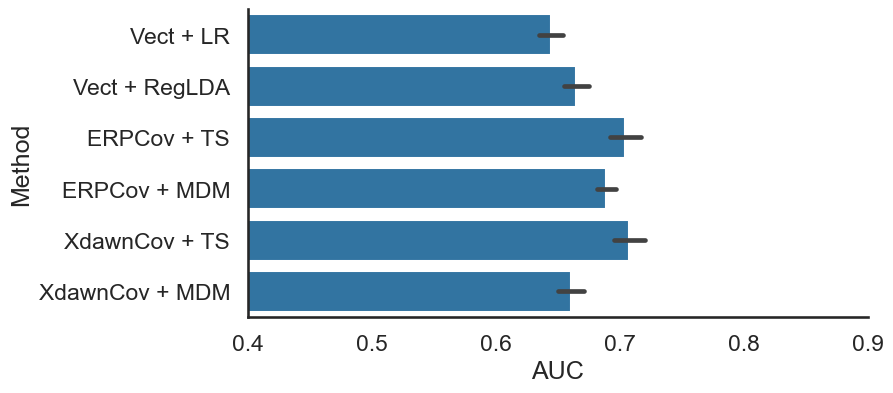

In [6]:
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

fig = plt.figure(figsize=(8, 4))
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 0.9)
sns.despine()